Aggregated Results (Averages):
          R^2         MSE       RMSE       MAE          MAPE  \
0    0.707457    0.094893   0.307484  0.227606  1.876715e-02   
1    0.761490    0.000683   0.025849  0.012984  1.623320e+10   
2    0.573156    0.000020   0.003527  0.002885  1.422057e-01   
3    0.942893    0.058721   0.242299  0.190408  2.472149e-02   
4    0.446878    0.424757   0.650919  0.358635  9.953699e+13   
..        ...         ...        ...       ...           ...   
92 -14.405418    0.000003   0.001043  0.000946  2.756600e+08   
93   0.699408    0.097324   0.311913  0.231369  1.905371e-02   
94   0.869341  153.216177  12.374499  7.819147  8.841573e+00   
95   0.977910    0.007085   0.084171  0.051890  5.797712e-03   
96   0.994837    0.003307   0.053899  0.018301  2.194656e-03   

             dataset        model  
0             houses   autopnpnet  
1             sulfur         cnet  
2          elevators  tabbaseline  
3           diamonds    tabpnpnet  
4          house_16H

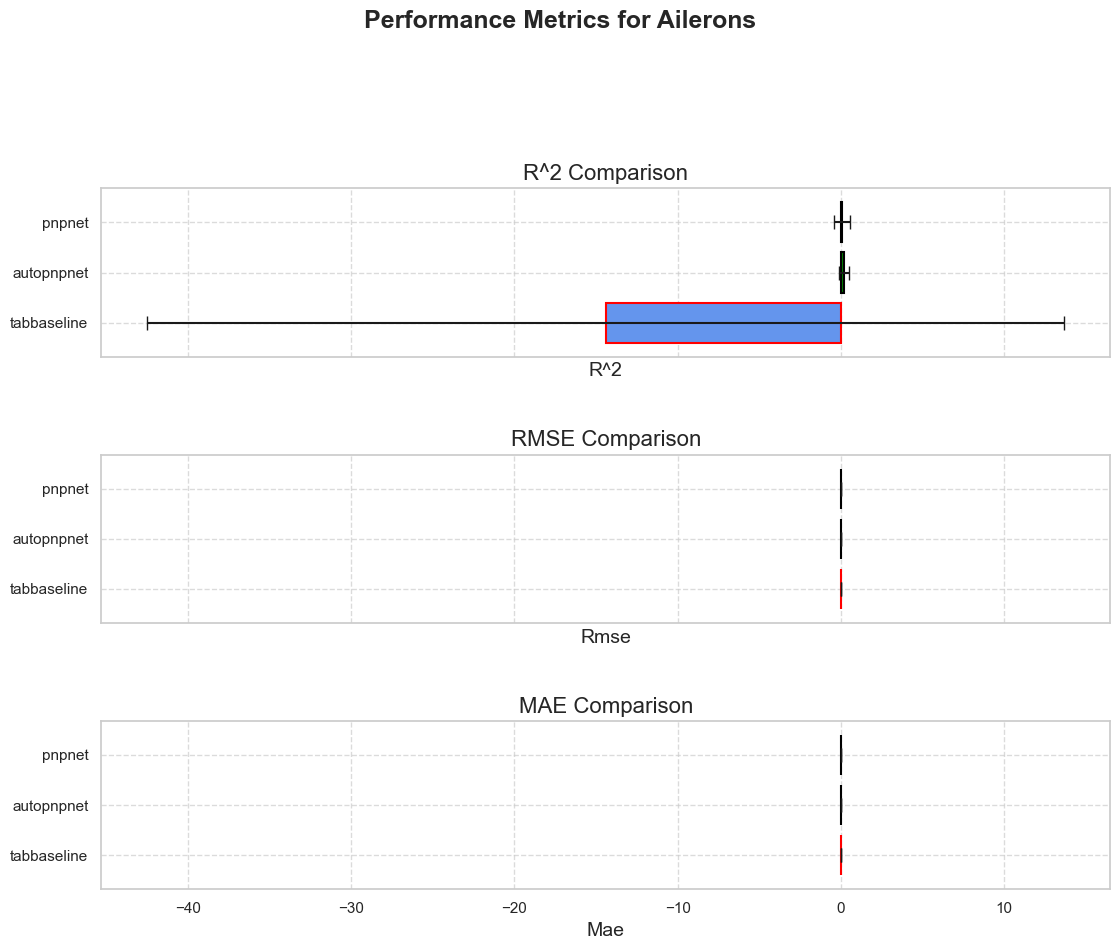

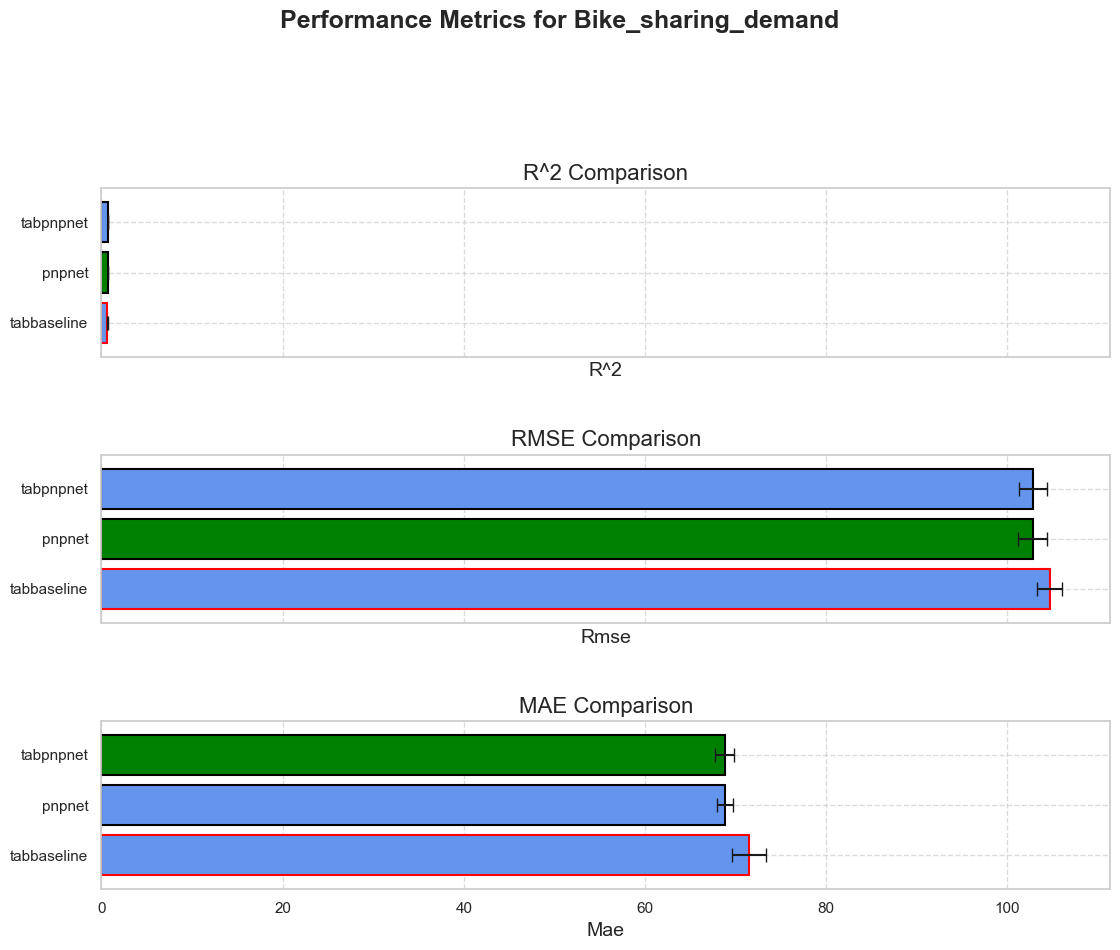

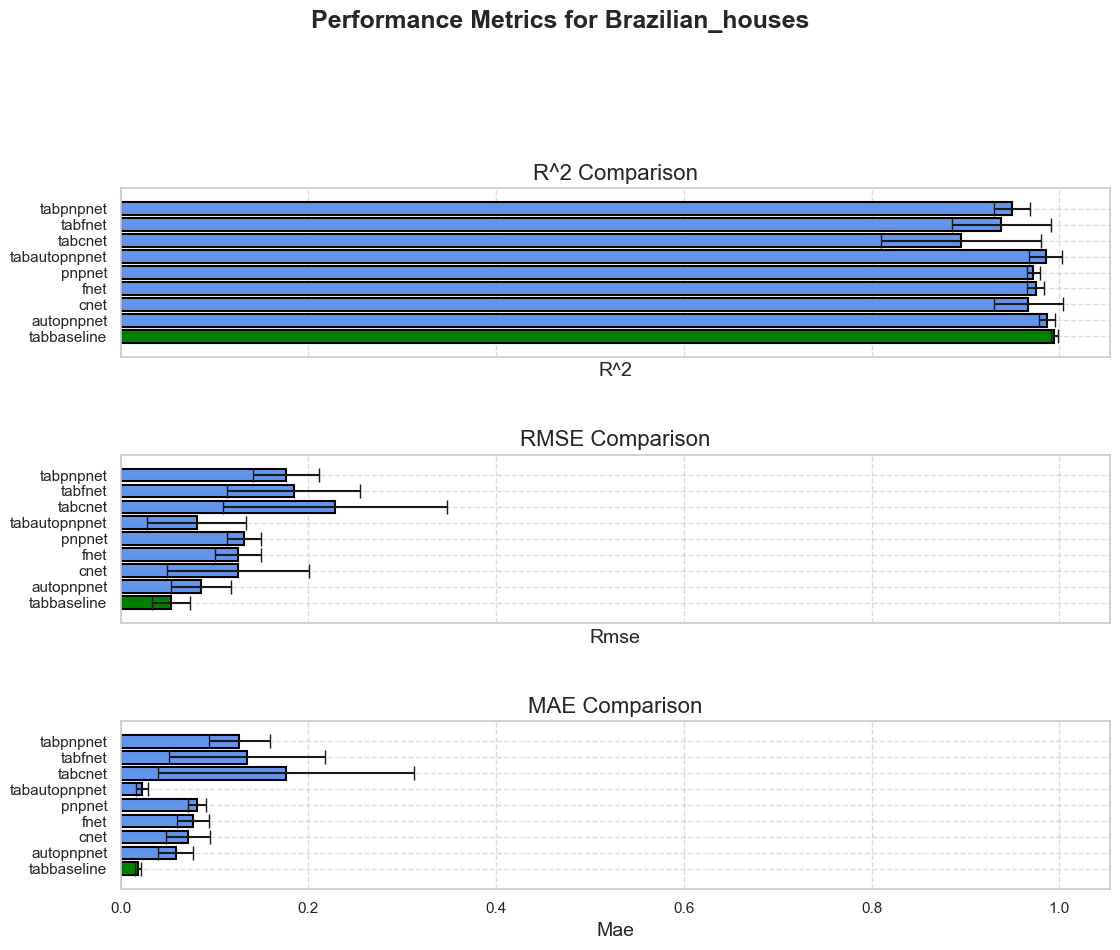

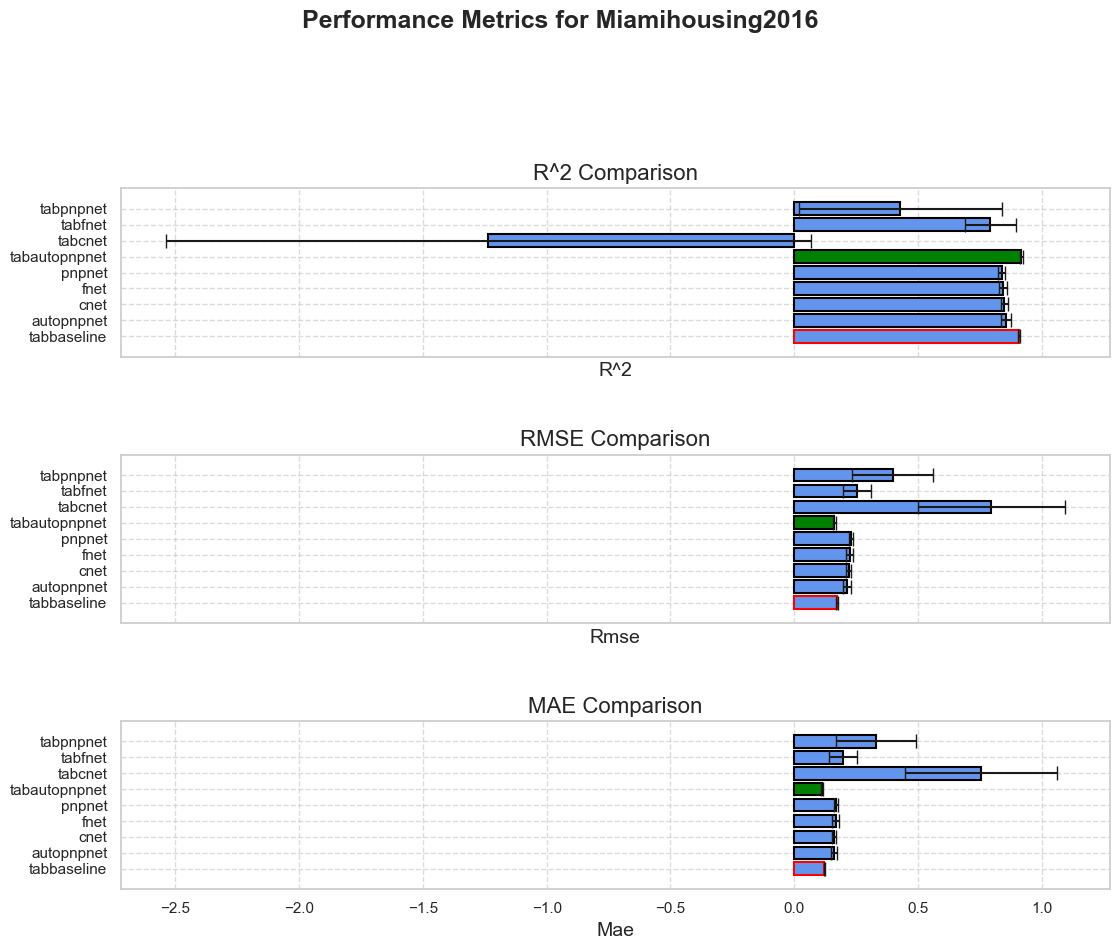

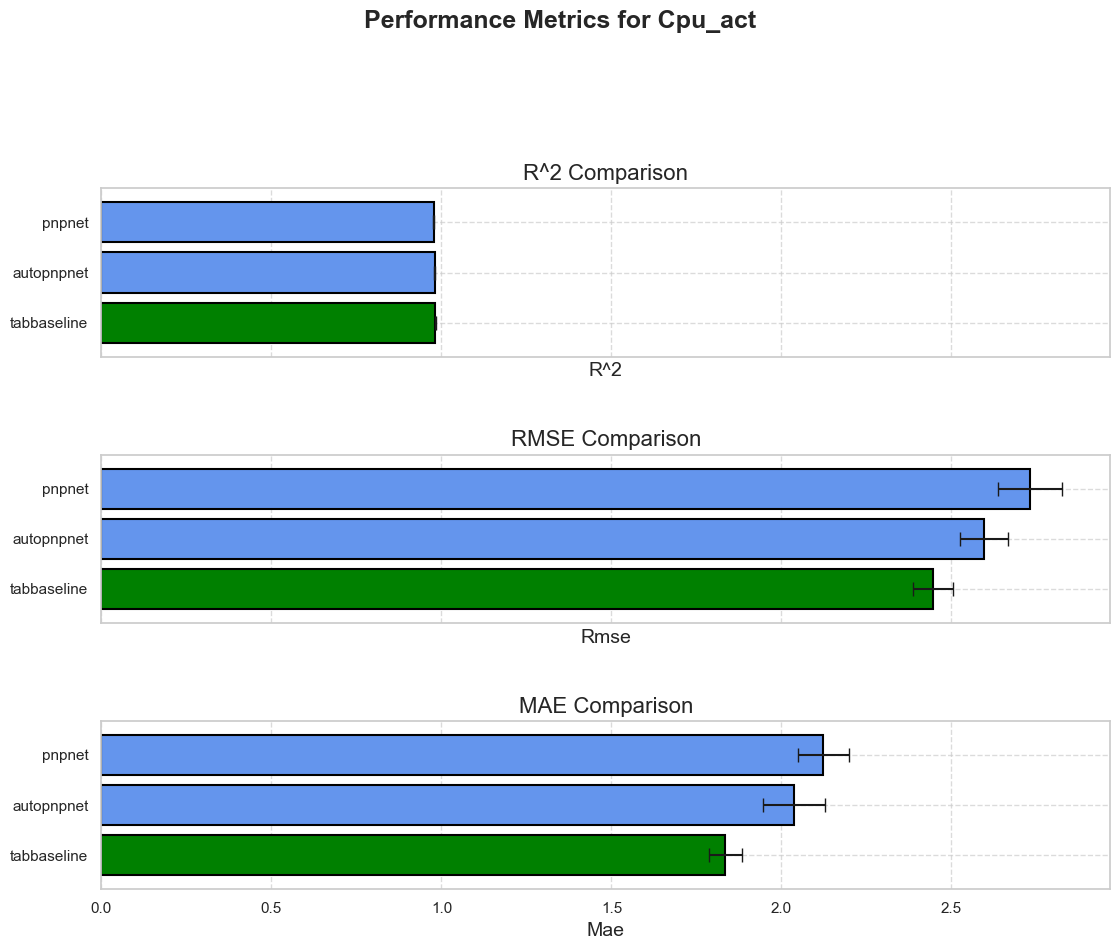

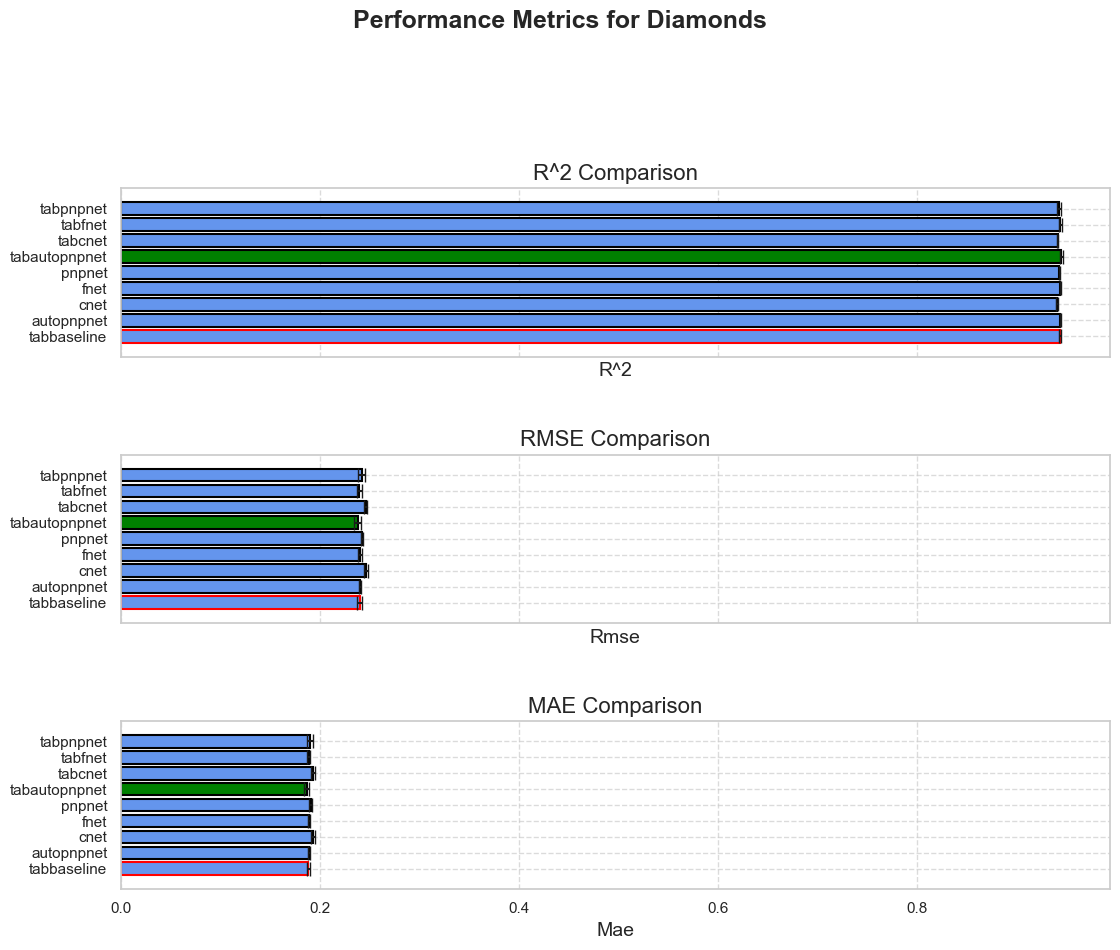

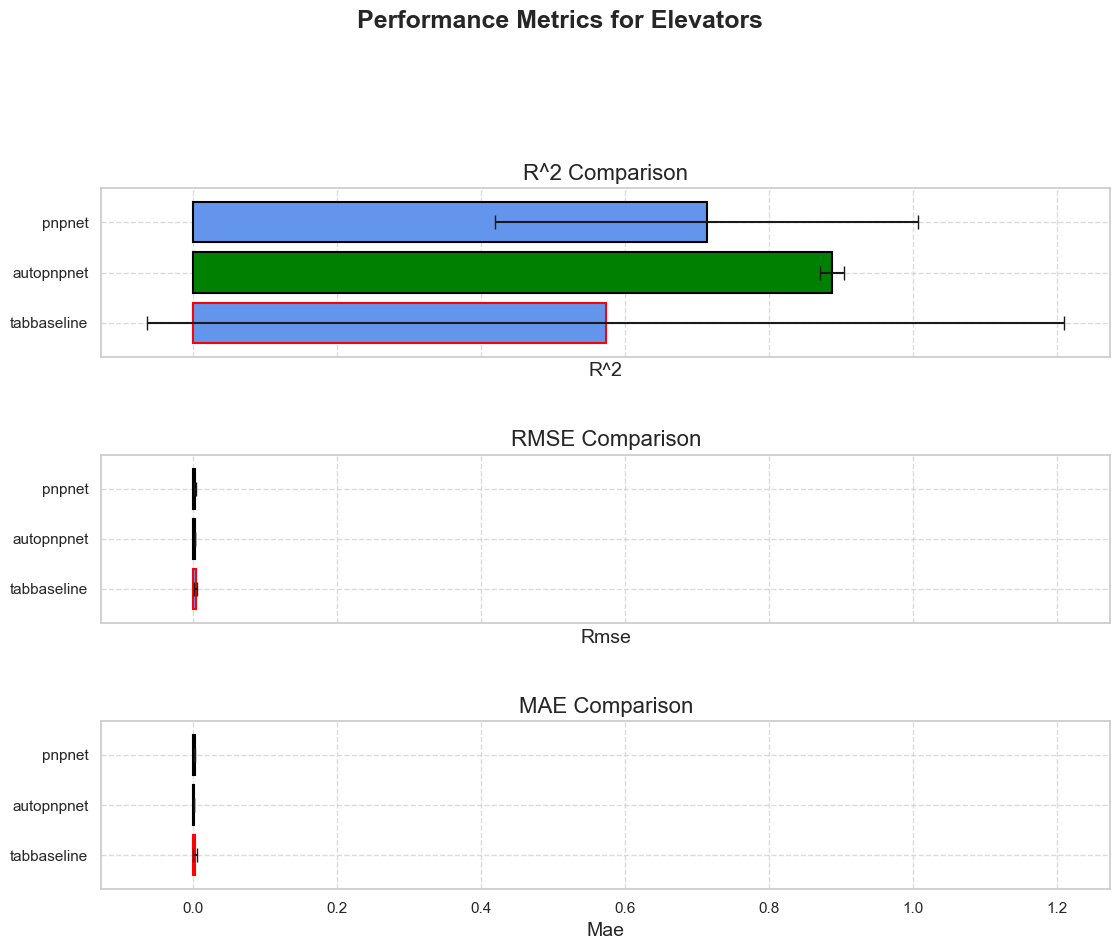

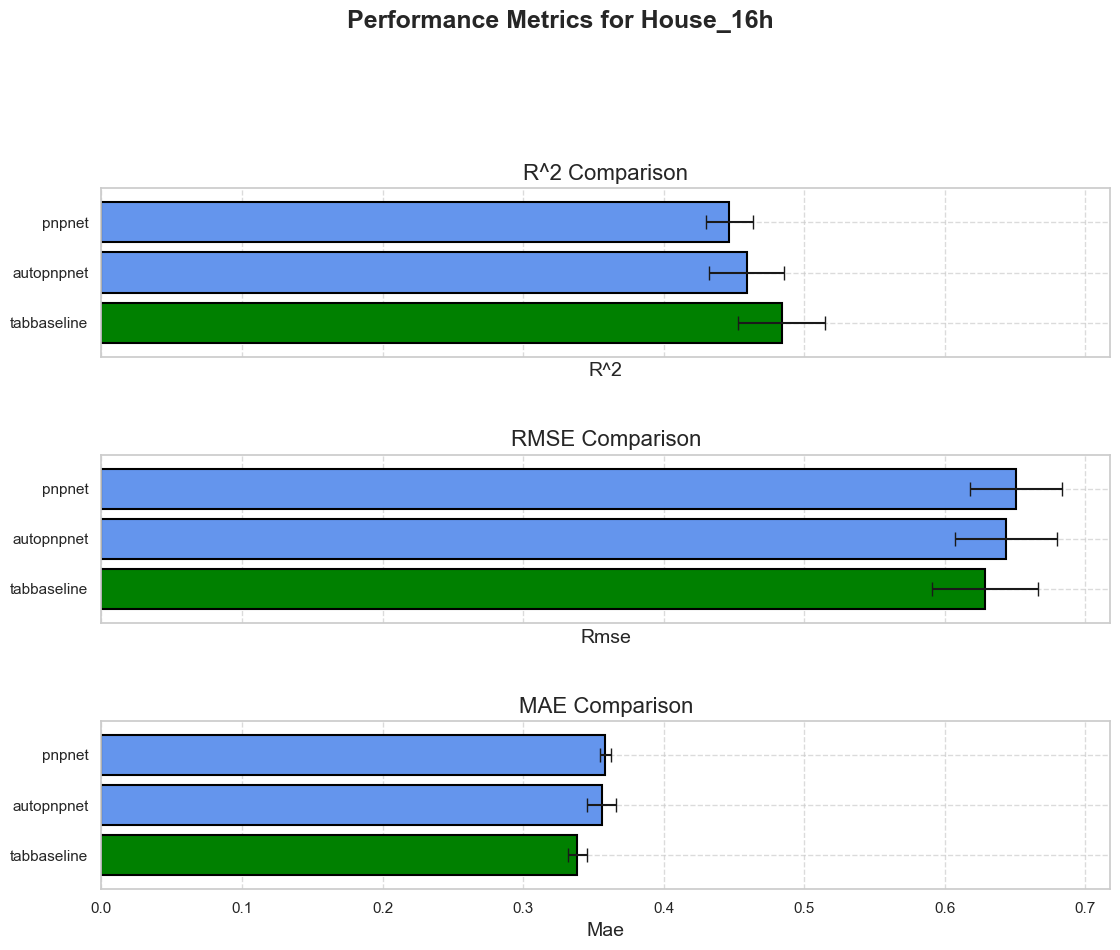

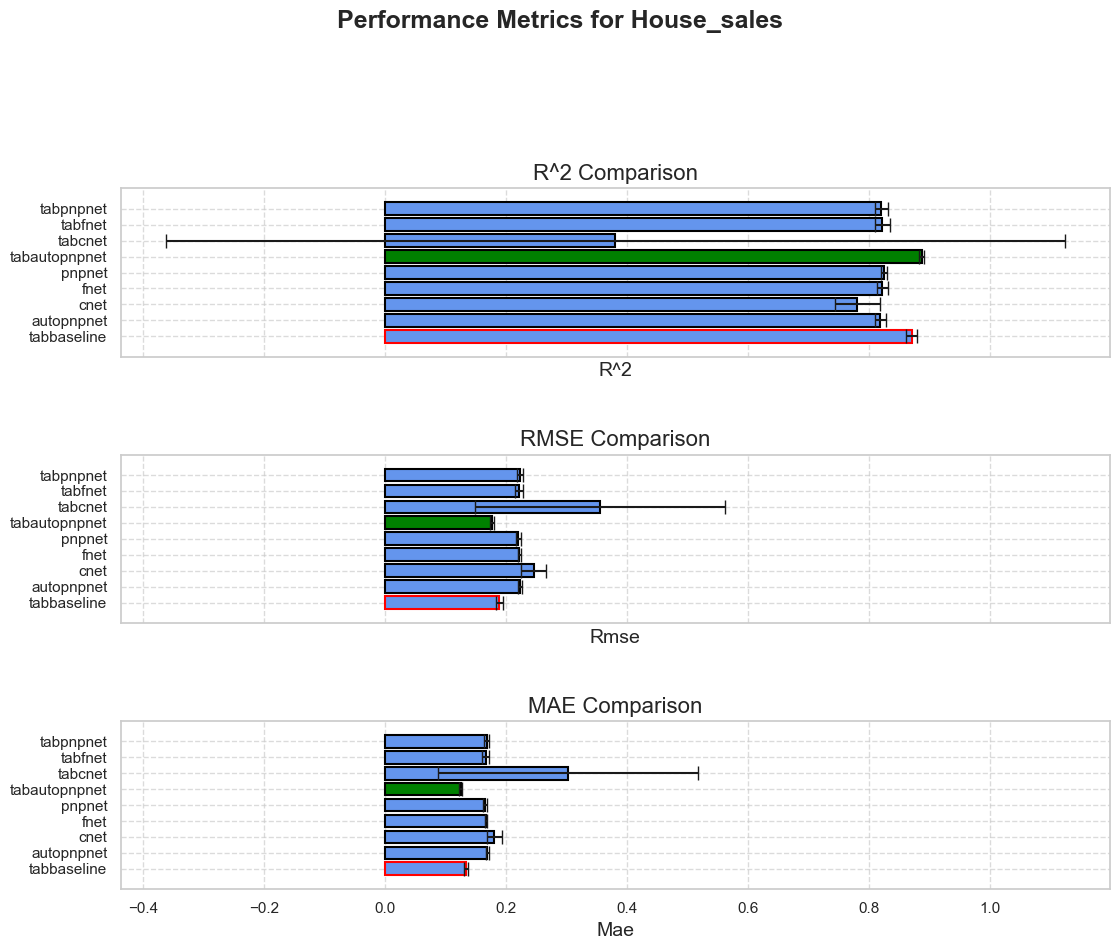

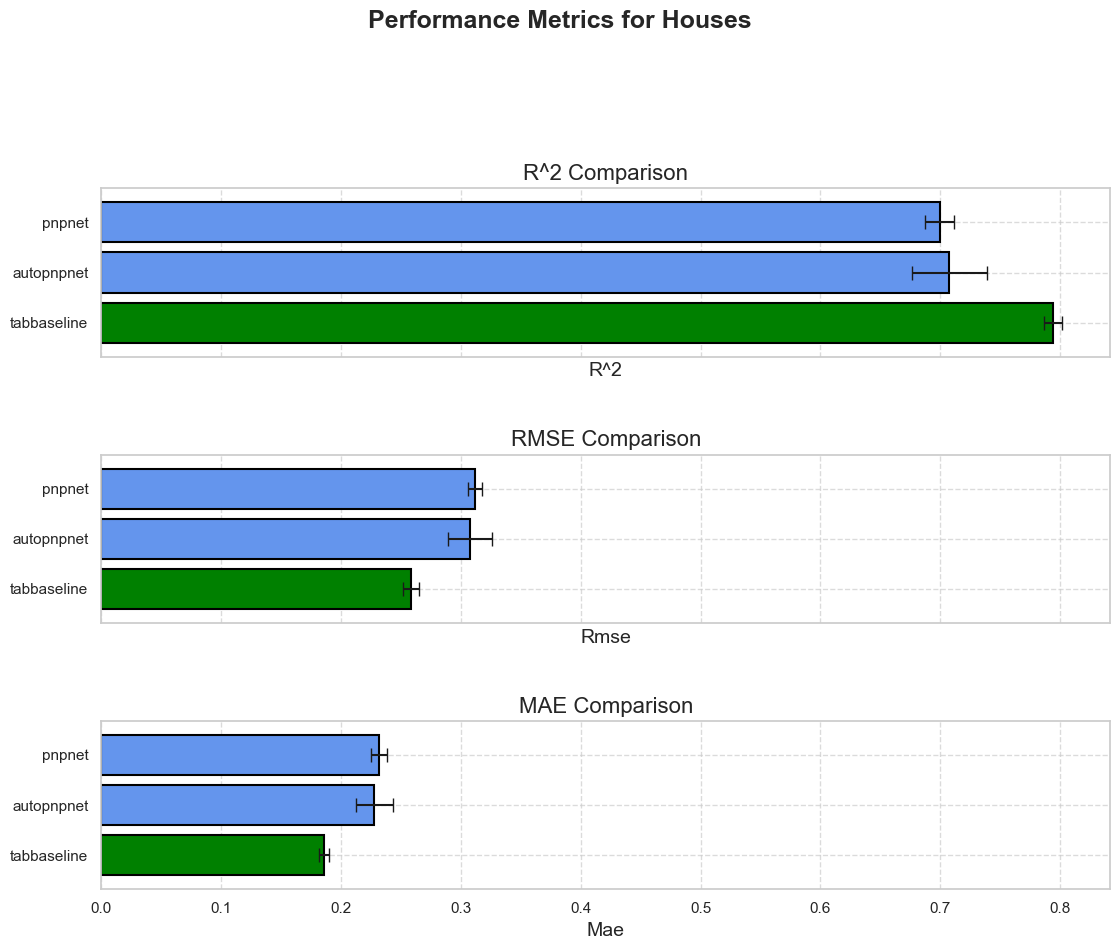

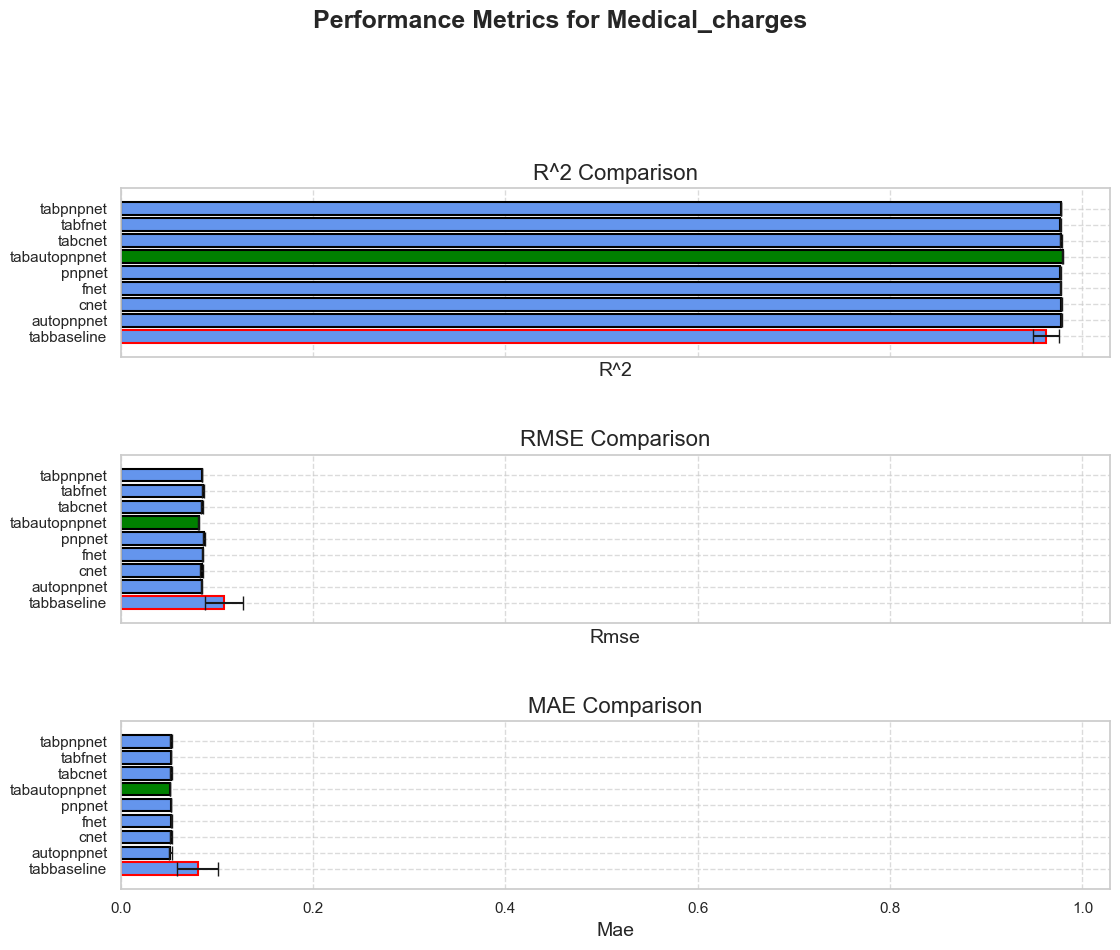

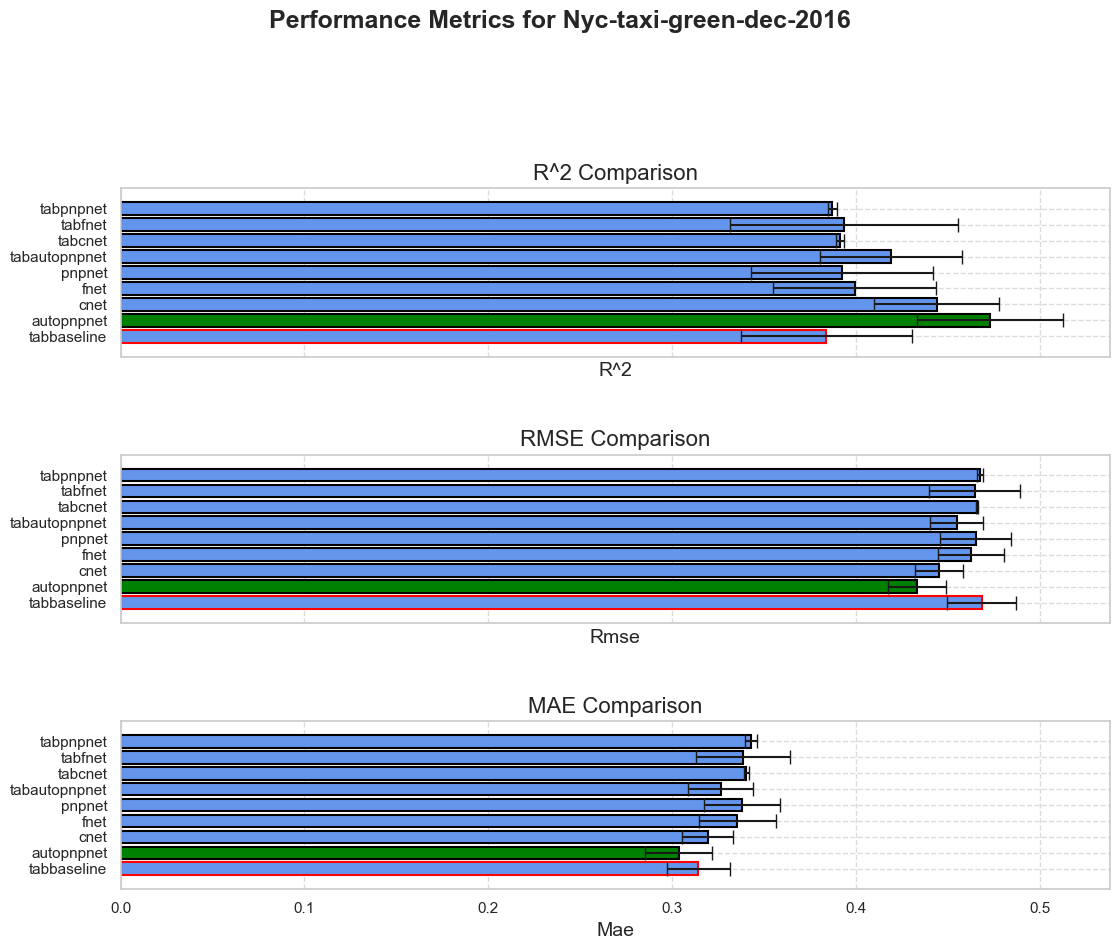

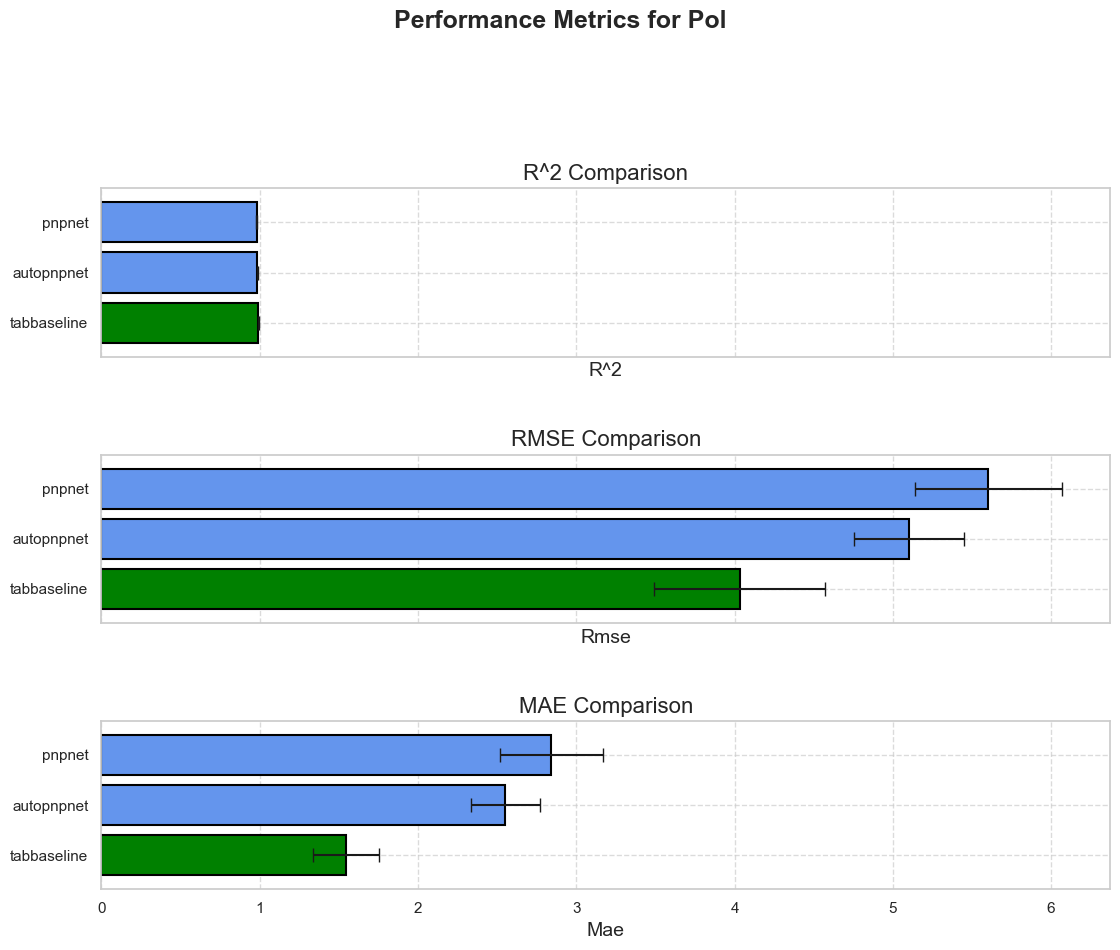

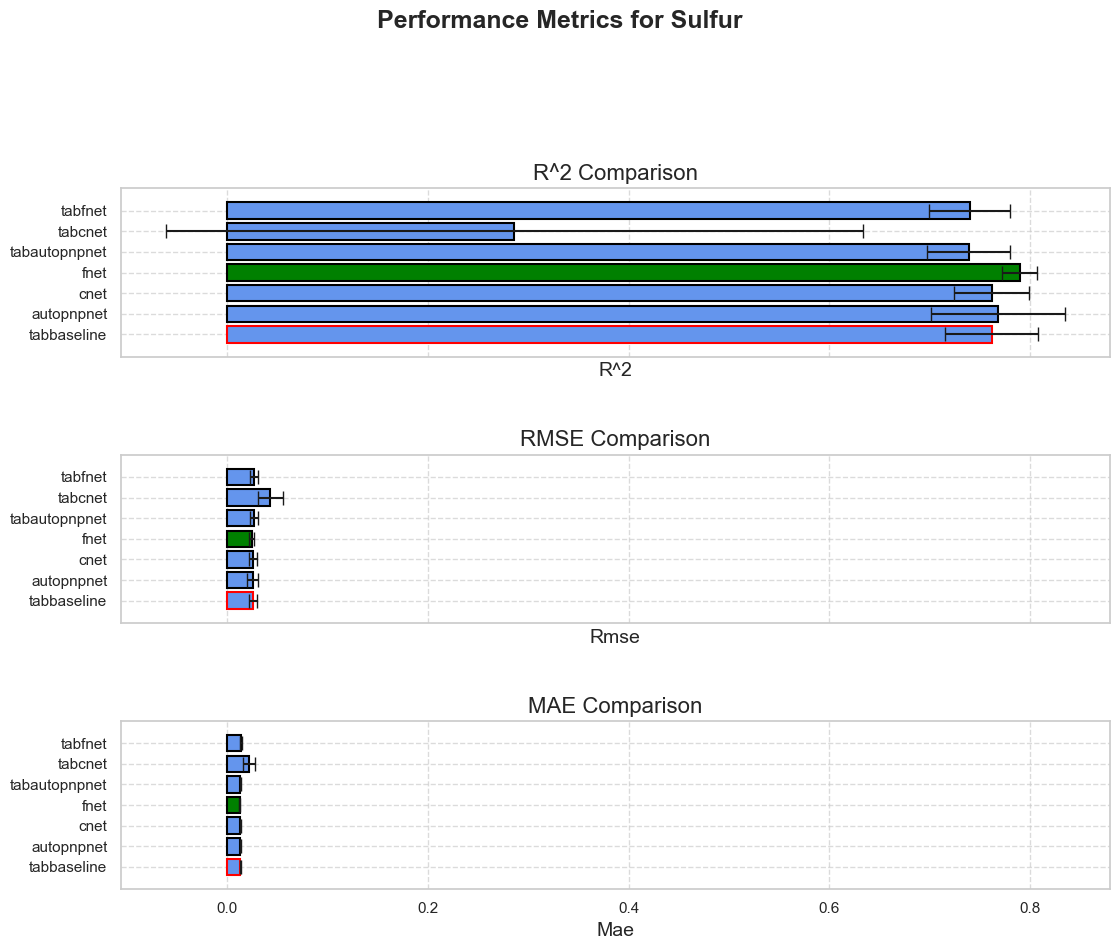

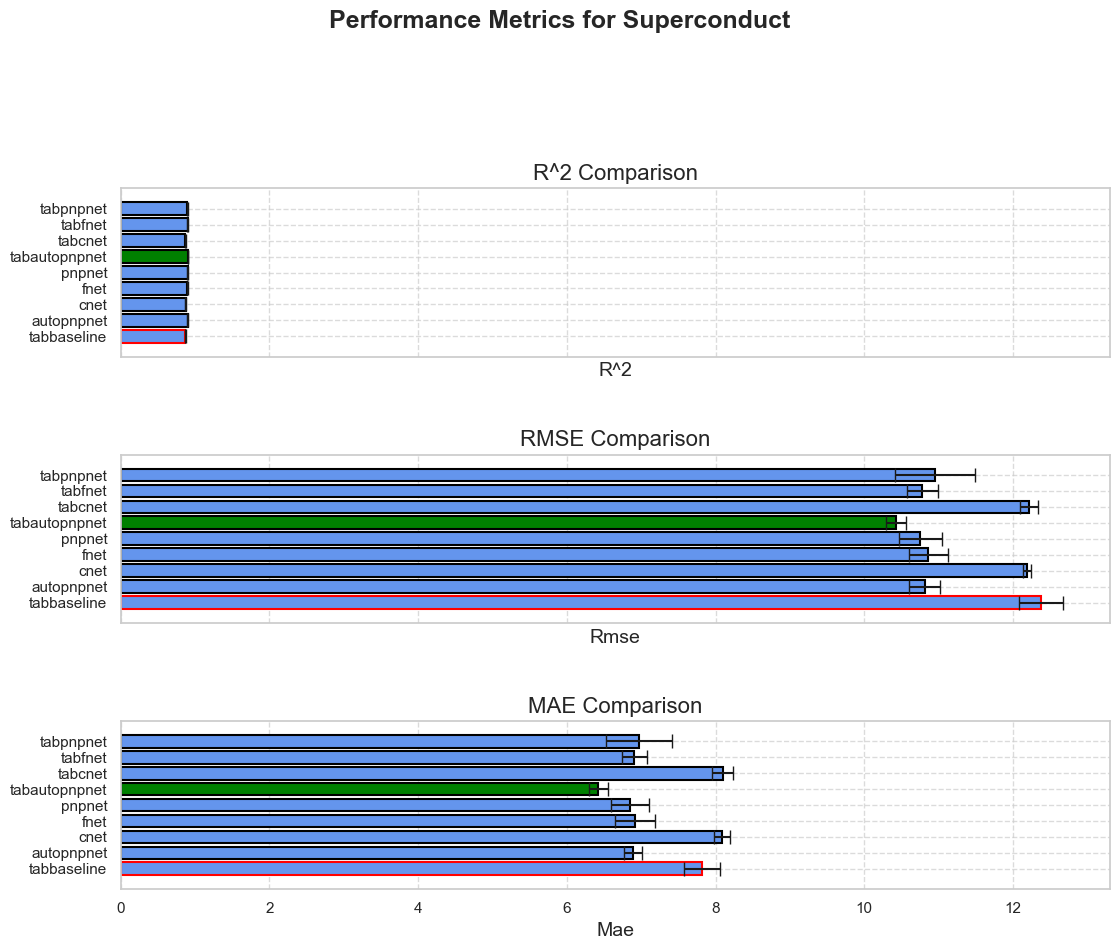

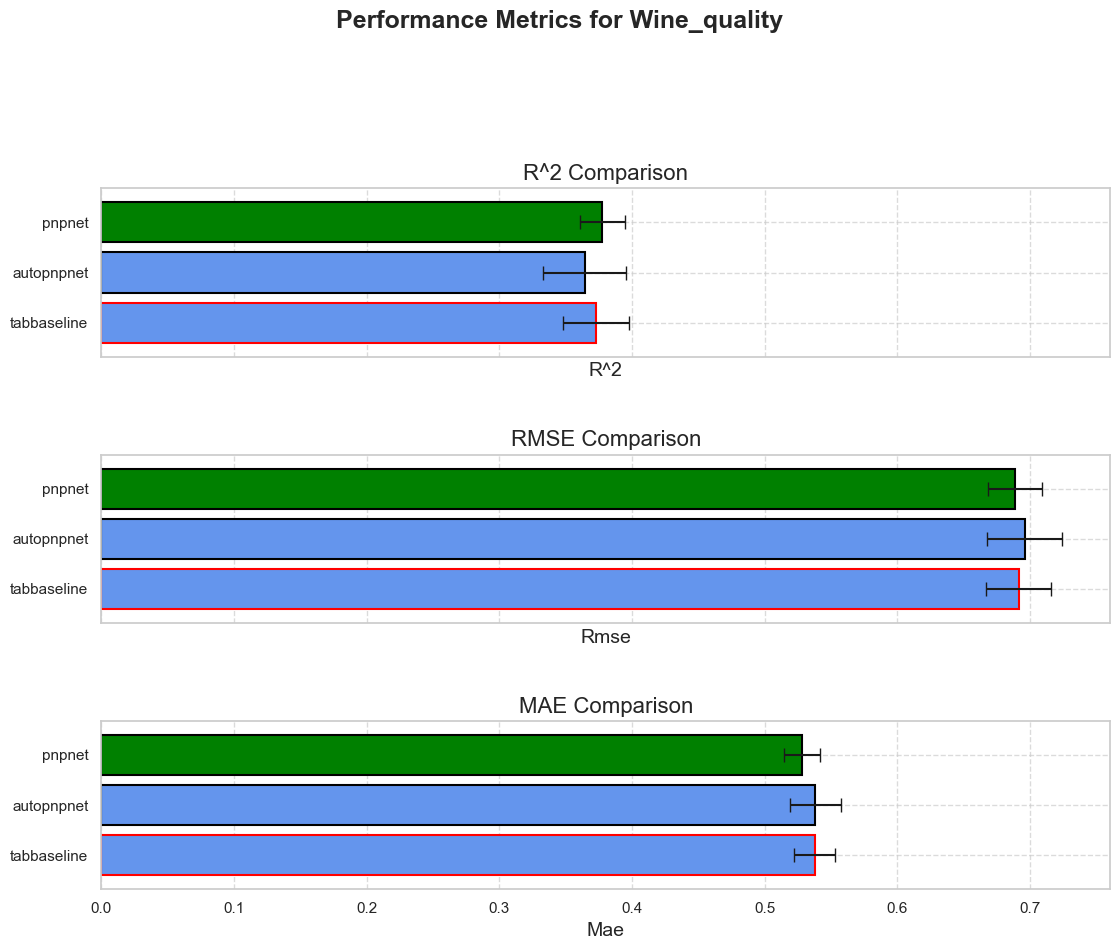

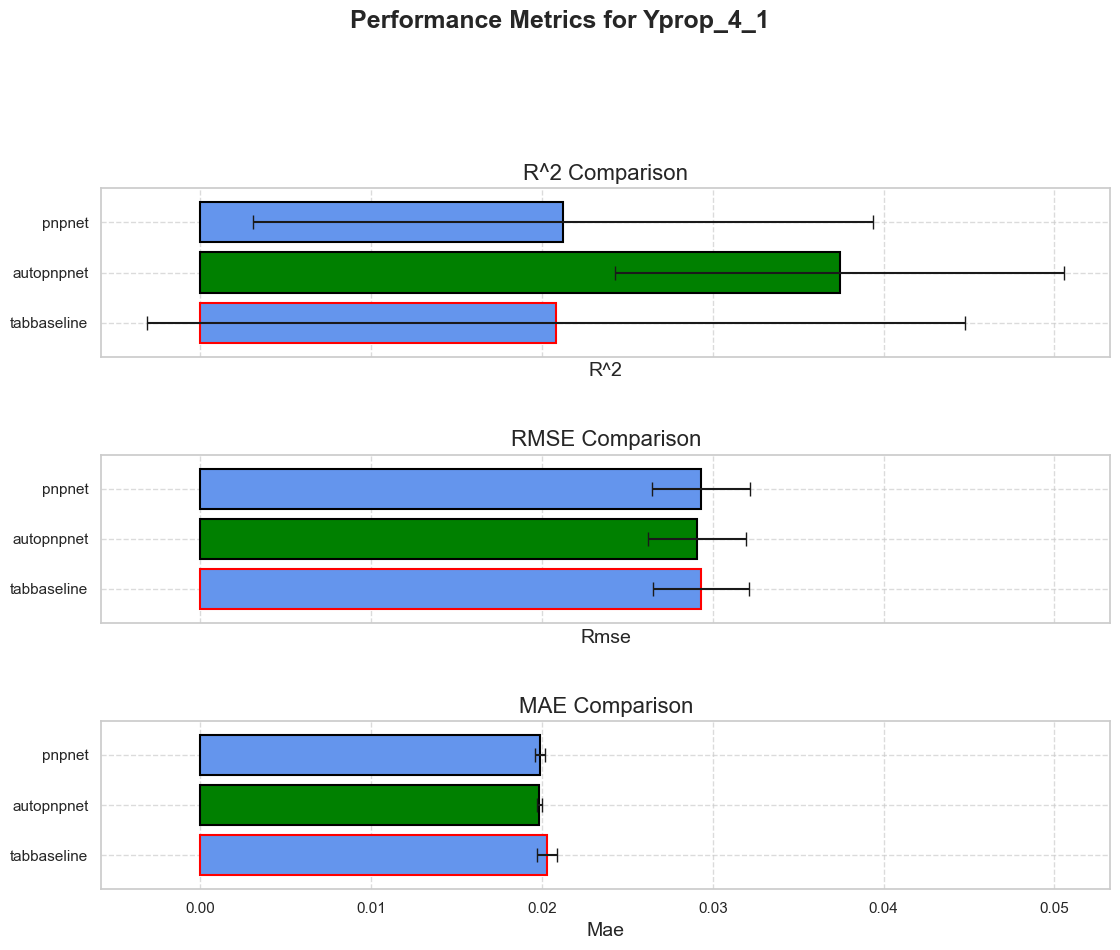

In [20]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Define the path to the directory containing experiment logs
log_dir = "../results/benchmark"

def load_metrics(json_path):
    """Load and return metrics from a JSON file."""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error loading {json_path}: {e}")
        return {}

def aggregate_metrics(log_dir):
    """Aggregate metrics from all experiment folders."""
    summary = []
    
    for dataset_model_folder in glob(f"{log_dir}/*__*"):
        dataset, model = os.path.basename(dataset_model_folder).split("__", 1)
        model = model.split("_")[0]
        
        fold_metrics = [
            load_metrics(metrics_file) for metrics_file in glob(f"{dataset_model_folder}/*_metrics.json")
            if isinstance(load_metrics(metrics_file), dict)
        ]

        if fold_metrics:
            metrics_df = pd.DataFrame(fold_metrics)
            avg_metrics = metrics_df.mean().to_dict()
            std_metrics = metrics_df.std().to_dict()
            avg_metrics.update({"dataset": dataset, "model": model})
            std_metrics.update({"dataset": dataset, "model": model})
            summary.append((avg_metrics, std_metrics))

    avg_summary_df = pd.DataFrame([s[0] for s in summary])
    std_summary_df = pd.DataFrame([s[1] for s in summary])
    return avg_summary_df, std_summary_df

def get_colors_and_edges_for_models(models, values, best_idx, highlight_model="tabbaseline"):
    """Assign fill colors and edge colors for each model."""
    colors = []
    edges = []
    
    for idx, model in enumerate(models):
        if idx == best_idx:
            colors.append('green')  # Highlight best model with green fill
            edges.append('black')
        elif model == highlight_model:
            colors.append('cornflowerblue')  # Regular color for "tabbaseline" fill
            edges.append('red')  # Red edges for "tabbaseline"
        else:
            colors.append('cornflowerblue')
            edges.append('black')
    
    return colors, edges

def plot_metrics_per_dataset(avg_summary_df, std_summary_df):
    """Plot R^2, RMSE, and MAE metrics for each dataset."""
    metrics_to_plot = ["R^2", "RMSE", "MAE"]
    
    for dataset, data in avg_summary_df.groupby("dataset"):
        std_data = std_summary_df[std_summary_df["dataset"] == dataset]
        
        # Sort models, placing "tabbaseline" first, then alphabetically by other model names
        data = data.set_index("model")
        std_data = std_data.set_index("model")
        sorted_index = sorted(data.index, key=lambda x: (x != "tabbaseline", x))
        data = data.loc[sorted_index].reset_index()
        std_data = std_data.loc[sorted_index].reset_index()
        
        fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 10), sharex=True)
        fig.suptitle(f"Performance Metrics for {dataset.capitalize()}", fontsize=18, weight='bold')
        
        for i, metric in enumerate(metrics_to_plot):
            ax = axes[i]
            values = data[metric]
            errors = std_data[metric]
            models = data["model"]
            
            # Identify the best model based on metric type
            best_idx = values.idxmax() if metric == "R^2" else values.idxmin()
            colors, edges = get_colors_and_edges_for_models(models, values, best_idx)

            ax.barh(models, values, xerr=errors, color=colors, edgecolor=edges, capsize=5, linewidth=1.5)
            ax.set_title(f"{metric.upper()} Comparison", fontsize=16)
            ax.set_xlabel(metric.capitalize(), fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.margins(y=0.1)
        
        plt.subplots_adjust(hspace=0.5)
        plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])
        plt.show()

# Run analysis
avg_summary_df, std_summary_df = aggregate_metrics(log_dir)
print("Aggregated Results (Averages):")
print(avg_summary_df)

# Save summary to CSV
avg_summary_df.to_csv("experiment_summary_avg.csv", index=False)

# Plot metrics for each dataset
plot_metrics_per_dataset(avg_summary_df, std_summary_df)
